### Imports

In [1]:
import pandas as pd
import re
import itertools   
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.lang.en import English
from booknlp.booknlp import BookNLP
from IPython.core.pylabtools import figsize
sns.set_theme(style="darkgrid")
figsize(25, 20)
pd.set_option('display.max_colwidth', None)
nlp = English()
tokenizer = nlp.tokenizer



/Users/neis/.local/share/virtualenvs/narrative_transportation-A8lJIXj7/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using device cpu


### Survey data and stories

In [2]:
def get_indexes(raw):
   if( not pd.isna(raw)):
      highlights = re.findall(r'\d+:', raw)
      return list(map(lambda x: int(x.replace(':', '')) - 1, highlights))

In [3]:
data_unfiltered = pd.read_csv('survey_responses.csv')
data = data_unfiltered
# data = data_unfiltered[(data_unfiltered['aphantasia_check'] == '5') | (data_unfiltered['aphantasia_check'] == '6')]
# data = data_unfiltered[(data_unfiltered['hours_read'] != '0-1 hours')]
data = data.drop(['StartDate', 'ResponseId', 'EndDate', 'IPAddress', 'Progress', 'Duration (in seconds)', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'Q_RecaptchaScore', 'UserLanguage'], axis=1)[data['Finished'] == 'True']
data['highlight_hp_high_1'] = data['highlight_hp_high_1'].map(get_indexes)
data['highlight_hp_high_2'] = data['highlight_hp_high_2'].map(get_indexes)
data['highlight_hp_low_1'] = data['highlight_hp_low_1'].map(get_indexes)
data['highlight_hp_low_2'] = data['highlight_hp_low_2'].map(get_indexes)
data['highlight_hero_high_1'] = data['highlight_hero_high_1'].map(get_indexes)
data['highlight_hero_high_2'] = data['highlight_hero_high_2'].map(get_indexes)
data['highlight_hero_low_1'] = data['highlight_hero_low_1'].map(get_indexes)
data['highlight_hero_low_2'] = data['highlight_hero_low_2'].map(get_indexes)

In [4]:
hp_high_sentences = list(open('hp_high.txt', 'r').read().split('\n'))
hp_low_sentences = list(open('hp_low.txt', 'r').read().split('\n'))
hero_high_sentences = list(open('hero_high.txt', 'r').read().split('\n'))
hero_low_sentences = list(open('hero_low.txt', 'r').read().split('\n'))


In [5]:
all_stories = ['hp_high', 'hp_low', 'hero_high', 'hero_low']
all_sentences = [hp_high_sentences, hp_low_sentences, hero_high_sentences, hero_low_sentences]

### Utility functions

In [34]:
def softmax(vec):
  exponential = np.exp(vec)
  weights = np.round(exponential / np.sum(exponential), decimals=2)
  return weights
 
vector = np.array([1, 2, 3, 4, 5, 6])
weights = softmax(vector)
print(weights)

[0.   0.01 0.03 0.09 0.23 0.63]


In [35]:
def group_highlights(sent, highlights, aphantasia):
   highlight_array = np.zeros(len(sent))
   for (x, y) in zip(highlights, aphantasia):
      if(x != None):
         highlight_array[x] += (1 + weights[int(y)-1])
   return highlight_array

In [8]:
def get_highlight_text(sent, bool_array):
   return [sent[i] for i in np.where(bool_array)[0]]

In [9]:
def show_highlight_results(storyName, sentences, data):
   column_inc = f"highlight_{storyName}_1"
   column_dec = f"highlight_{storyName}_2"
   y1 = group_highlights(sentences, data[column_inc], data['aphantasia_check'])
   y2 = group_highlights(sentences, data[column_dec], data['aphantasia_check'])

   return (y1, y2)

In [10]:
def get_sentence(num, story):
   story_tokens = tokens[story]
   row = story_tokens[story_tokens['token_ID_within_document'] == num]['sentence_ID']
   if(len(row) > 0):
      return story_tokens[story_tokens['token_ID_within_document'] == num]['sentence_ID'].iloc[0]
   else:
      return -1

In [11]:
def get_supersense(story):
   supersense_df = pd.read_csv(f"results/{story}/{story}.supersense", delimiter='\t')
   story_list = list(itertools.repeat(story, len(supersense_df['start_token'])))
   supersense_df['sentence'] = list(map(get_sentence, supersense_df['start_token'], story_list))
   return supersense_df

In [12]:
def count_cognition_words(supersense, sent):
   cognition_counts = np.zeros(len(sent))
   for i in range(len(sent)):
      supersense_tokens = supersense[supersense['sentence'] == i]['supersense_category']
      for j in supersense_tokens:
         if(j == 'noun.cognition' or j == 'verb.cognition'):
            cognition_counts[i] += 1
      cognition_counts[i] = (cognition_counts[i] / len(list(tokenizer(sent[i]))))*100
   return cognition_counts

In [13]:
def get_concreteness_scores(sentence):
   tokens = tokenizer(sentence)
   score = 0
   for token in tokens:
      row = concreteness_scores[concreteness_scores['Word'] == str(token)]
      if(len(row) > 0):
         score = score + row['Conc.M'].iloc[0]
   return score / len(tokens)

In [14]:
def get_overlapping_highlights(inc, dec):
   overlaps = []
   for row in range(len(inc)):
      if inc[row] != 0 and dec[row] != 0:
         overlap = inc[row] if inc[row] < abs(dec[row]) else abs(dec[row])
         overlaps.append(overlap)
      else:
         overlaps.append(0)
   return overlaps

### Process highlights

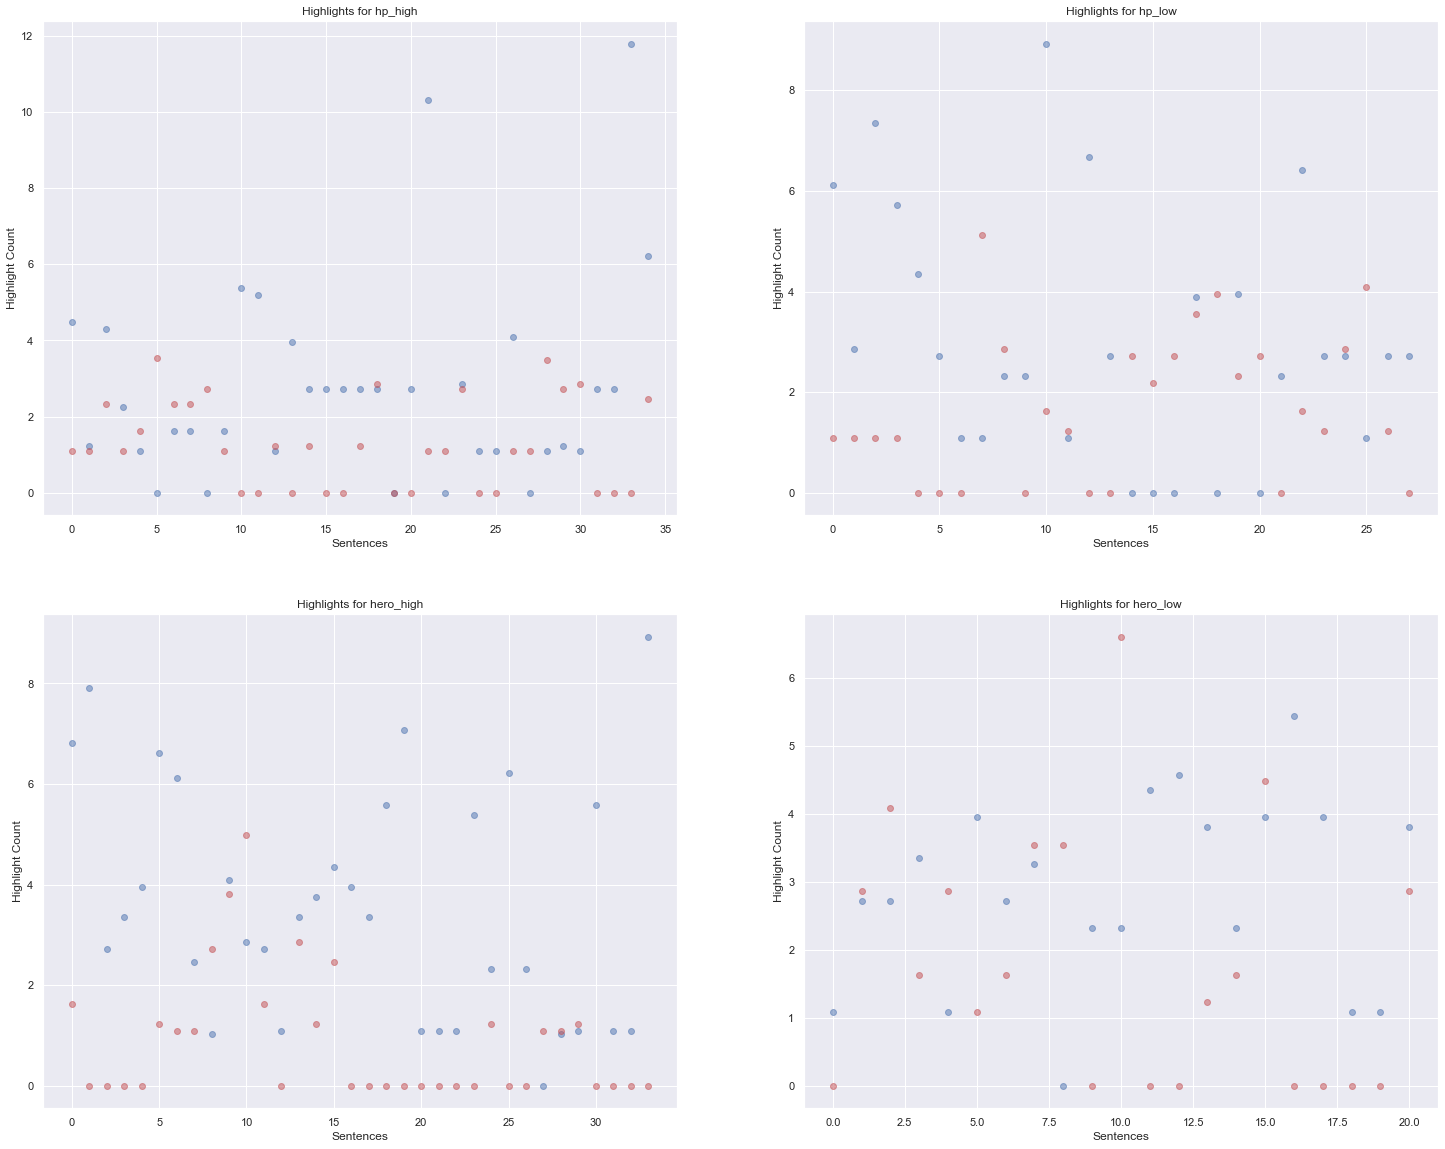

In [53]:
counts_inc = dict(zip(all_stories, np.zeros(len(all_stories))))
counts_dec = dict(zip(all_stories, np.zeros(len(all_stories))))
sentence_counts = dict(zip(all_stories, np.zeros(len(all_stories))))
combined_highlights = dict(zip(all_stories, np.zeros(len(all_stories))))
overlapping_highlights = dict(zip(all_stories, np.zeros(len(all_stories))))
sentences = dict(zip(all_stories, all_sentences))

fig, ax = plt.subplots(2, 2)
count = 0
axes = [[0, 0], [0, 1], [1, 0], [1, 1]]

for story in all_stories:
   counts_inc[story], counts_dec[story] = show_highlight_results(story, sentences[story], data) # show individual results by passing in a row: data[1:2]
   sentence_counts[story] = pd.DataFrame(sentences[story], columns=['sentence'])
   sentence_counts[story]['increase'] = counts_inc[story]
   sentence_counts[story]['decrease'] = counts_dec[story]
   sentence_counts[story]['combined'] = counts_inc[story] - counts_dec[story]
   combined_highlights[story] = pd.DataFrame(sentences[story], columns=['sentence'])
   combined_highlights[story]['combined_highlights'] = np.round(counts_inc[story] - counts_dec[story], decimals=2)
   overlapping_highlights[story] = pd.DataFrame(sentences[story])
   overlapping_highlights[story]['overlap'] = get_overlapping_highlights(counts_inc[story], counts_dec[story])

   # display(sentence_counts[story].head())
   # Plot the highlights
   x = np.linspace(0, len(sentences[story]) -1, len(sentences[story]))
   ax1 = axes[count][0]
   ax2 = axes[count][1]
   ax[ax1, ax2].scatter(x, counts_inc[story], alpha=.5, color='b')
   ax[ax1, ax2].scatter(x, counts_dec[story], alpha=.5, color='r')
   ax[ax1, ax2].set_xlabel("Sentences")
   ax[ax1, ax2].set_ylabel("Highlight Count")
   ax[ax1, ax2].set_title(f"Highlights for {all_stories[count]}")

   count +=1
plt.show()


In [54]:
for story in all_stories:
   display(overlapping_highlights[story].sort_values(by='overlap', ascending=False).head(10))

,0,overlap
23,"Dudley, Where had the Veil sent him?",2.72
18,"Why, even at that very moment, he couldn't walk away.",2.72
34,"Hagrid stood in the doorway, looking very impressive.",2.46
2,The one that Sirius had fallen behind.,2.32
6,"He wondered, briefly, why he was there.",1.63
7,"Ginny was at home, she was pregnant, she needed him.",1.63
14,"There were more, many more, but none of them close to him.",1.23
29,"His uncle didn't seem to know that, though, and shouted ""Who's there, I warn you-I'm armed!""",1.23
17,Why he couldn't look away.,1.23
9,"Voldemort was gone, true.",1.09


,0,overlap
17,Most of my concentration that evening was on keeping Bella from marching over to the Gryffindor table and making a scene.,3.55
24,"I warned Sirius of Bella’s approach, and Sirius managed to avoid her until late in the afternoon.",2.72
19,"That ""discussion"" was the reason for my presence outside of Gryffindor Tower on the first morning of the new term;.",2.32
8,I was not about to let a Bellatrix Black temper tantrum ruin the glow of my first night as a prefect.,2.32
22,"He was flanked by three boys, none of whom I paid much attention to.",1.63
10,Bella continued to mutter angrily and slightly threateningly under her breath until Professor McGonagall shot her a filthy look;.,1.63
23,"I would like to say that my first encounter with Remus Lupin stands out clearly in my mind, but really, all it left was a vague impression of brown hair and an honest smile.",1.23
26,The argument progressed along predictable lines: Sirius was disgracing the family and Bellatrix was blaming him for something he claimed to not have much control over,1.23
7,"I know just how irritating I was being, and I stand by it.",1.09
25,The resulting argument wasn’t pretty; their arguments never were.,1.09


,0,overlap
9,"He still had a few posters up from some of his other favorite heroes, but he’d changed his sheets to a plain black set that he’d found collecting dust in the linen closet paired with a gold pillowcase.",3.81
13,"He had thought it would be painful and it was in some ways, but it was mostly familiar, like his analysis was the only part of himself that hadn’t shattered alongside his hero dream.",2.86
10,"It wasn’t official merchandise, but it reminded Izuku of Eraserhead anyway.",2.86
15,"He’d found it several years earlier and quickly figured out that a lot of underground heroes used it to communicate with each other, since it offered encrypted chats and accounts were only known by random numbers, rather than usernames.",2.46
0,"Even after an hour-long shower, Izuku still felt the weight of the past 24 hours clinging to his skin.",1.63
11,"It had taken a few days for him to gather the courage, but Izuku had finally sat down and updated his hero analysis notebooks, leaving out the parts on All Might’s secret weakness.",1.63
5,Izuku went to bed crying for his broken dream.,1.23
14,"That was why he found himself, during his latest bout with insomnia, browsing a lesser known hero forum.",1.23
24,Izuku was hyperventilating.,1.23
6,His room looked empty without all his All Might merch.,1.09


,0,overlap
15,"The man held out the remote and seemed to shout something to the hero from the roof, but the hero continued to scale the wall and shot himself all the way to the top with a large blast of fire.",3.95
7,"She didn’t know his quirk, but she just told the shopkeeper that it was a minor quirk that let him see slightly better and got away with it.",3.26
20,"Himiko stumbled, her hand slipping away from Kumiko’s, and she screamed for Himiko as she dove out of the way of the falling debris.",2.86
2,"She knew that if she returned, her parents would punish her for running away, and that was not exactly the most ideal situation.",2.72
1,"First, her older sister was kicked out of their own house unjustly by her parents, so she ran away from home to accompany her and make sure Himiko didn’t die.",2.72
10,"Kumiko bought a simple cap to cover her hair at work (her disguises only lasted for so long without training and she had very little endurance, and she soon found out that they began dissolving from top down - thus the hat), and Himiko bought herself a cheap winter coat, as it was starting to get chilly in the city.",2.32
6,"A few months from then, Kumiko managed to get a job moving boxes for a nearby shop, disguised as a young boy she’d seen on the streets once.",1.63
14,"Stopping in front of their alleyway, the escaping man began scaling the wall of the multi-story building to their right, and the hero followed.",1.63
3,"This caused some problems: no money, no shelter, no food or water.",1.63
13,Kumiko peeked outside to see a flaming hero chasing a man holding some sort of remote.,1.23


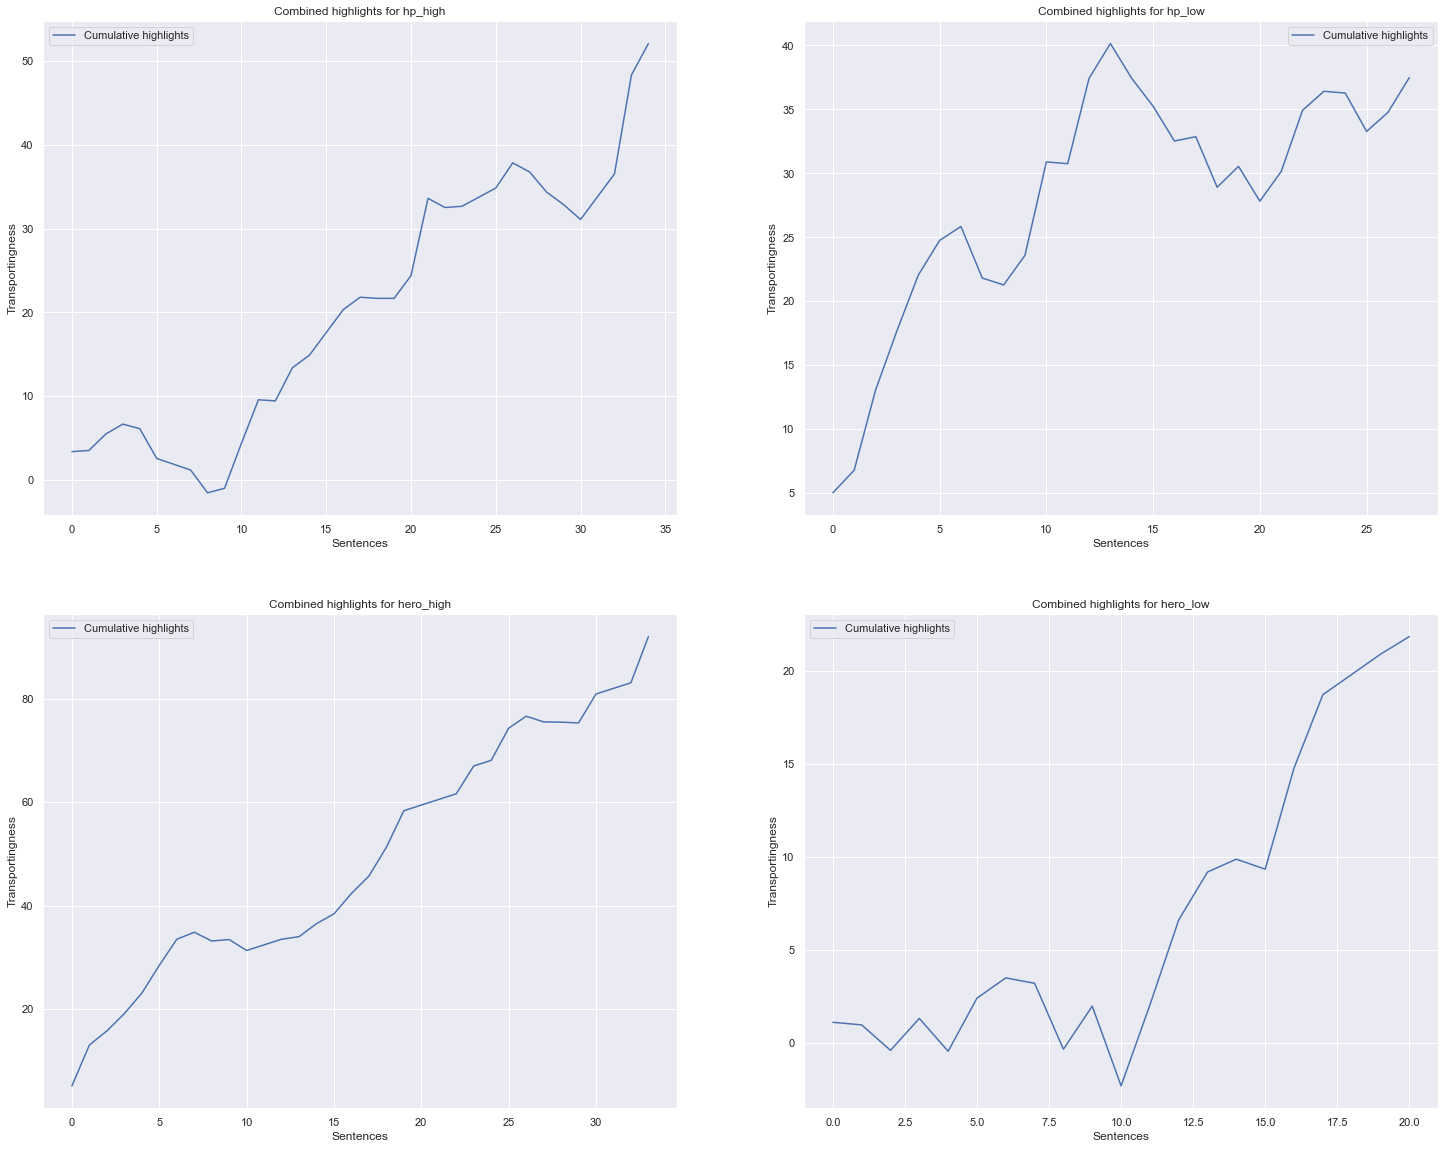

In [55]:


fig, ax = plt.subplots(2, 2)
count = 0

for story in all_stories:
   cdf = np.cumsum(sentence_counts[story]['combined'])
   # Plot the highlights
   x = np.linspace(0, len(sentences[story]) -1, len(sentences[story]))
   ax1 = axes[count][0]
   ax2 = axes[count][1]
   ax[ax1, ax2].plot(x, cdf, color='b', label="Cumulative highlights")
   ax[ax1, ax2].set_xlabel("Sentences")
   ax[ax1, ax2].set_ylabel("Transportingness")
   ax[ax1, ax2].set_title(f"Combined highlights for {all_stories[count]}")
   ax[ax1, ax2].legend()
   count +=1

plt.show()

In [67]:
for story in all_stories:
   df = combined_highlights[story]
   display(df.style.background_gradient(axis=0, gmap=df['combined_highlights'], cmap='RdBu',  vmin=-3.0, vmax=6.0))

,sentence,combined_highlights
0,He'd been dreaming of it since the defeat of Voldemort.,3.400000
1,"The Veil, that is.",0.140000
2,The one that Sirius had fallen behind.,1.970000
3,"The last time he'd dreamed about the Department of Mysteries, Sirius had died.",1.170000
4,"The world had also finally woken up to the truth about Voldemort, but the price had been too high for him to be grateful.",-0.540000
5,"And once the truth was out, the attacks had gotten worse.",-3.550000
6,"He wondered, briefly, why he was there.",-0.690000
7,"Ginny was at home, she was pregnant, she needed him.",-0.690000
8,Yet he could not seem to stay away.,-2.720000
9,"Voldemort was gone, true.",0.540000


,sentence,combined_highlights
0,"""What the hell just happened?"" Bella hissed at me from across the table.",5.030000
1,I looked down the Slytherin table;.,1.770000
2,"Lucius Malfoy, my fellow prefect, was wearing an expression on his face that was a cross between sympathy and amusement.",6.260000
3,Narcissa looked as if she was about to vomit.,4.630000
4,"""The hat put him into Gryffindor,"" I replied in a matter of fact voice.",4.350000
5,"""I know he was sorted into Gryffindor I’m not blind Andromeda.""",2.720000
6,"""Well, you did ask...""",1.090000
7,"I know just how irritating I was being, and I stand by it.",-4.030000
8,I was not about to let a Bellatrix Black temper tantrum ruin the glow of my first night as a prefect.,-0.540000
9,"She had obviously, and predictably, taken the result of Sirius’ sorting as a personal offense.",2.320000


,sentence,combined_highlights
0,"Even after an hour-long shower, Izuku still felt the weight of the past 24 hours clinging to his skin.",5.180000
1,"All Might looked down on him from every wall in his room, judgmental eyes staring straight into his soul.",7.900000
2,You can’t be a hero.,2.720000
3,Not without a quirk.,3.350000
4,Be realistic.,3.950000
5,Izuku went to bed crying for his broken dream.,5.380000
6,His room looked empty without all his All Might merch.,5.030000
7,"It wasn’t that Izuku hated All Might now, it’s just that every time he looked at the smiling hero, all he could think was you can’t be a hero.",1.370000
8,Just because Izuku was finally coming to terms with that fact didn’t mean he needed it playing on a loop in his head every time he’s at home.,-1.690000
9,"He still had a few posters up from some of his other favorite heroes, but he’d changed his sheets to a plain black set that he’d found collecting dust in the linen closet paired with a gold pillowcase.",0.280000


,sentence,combined_highlights
0,Kumiko Toga was not having a good day.,1.090000
1,"First, her older sister was kicked out of their own house unjustly by her parents, so she ran away from home to accompany her and make sure Himiko didn’t die.",-0.140000
2,"She knew that if she returned, her parents would punish her for running away, and that was not exactly the most ideal situation.",-1.370000
3,"This caused some problems: no money, no shelter, no food or water.",1.720000
4,"Himiko proposed that they steal food and other necessities from stores, but Kumiko didn’t like the idea of stealing from smaller stores and managed to convince her sister to only steal from people who could afford to lose some money.",-1.770000
5,"They set up a shelter tucked into an alleyway using anything waterproof or durable that they could find in a dumpster nearby, and luckily they had also found some old blankets and fabric they could use for bedding.",2.860000
6,"A few months from then, Kumiko managed to get a job moving boxes for a nearby shop, disguised as a young boy she’d seen on the streets once.",1.090000
7,"She didn’t know his quirk, but she just told the shopkeeper that it was a minor quirk that let him see slightly better and got away with it.",-0.290000
8,"There were a few slip-ups where she forgot what she’d called herself or what the boy had looked like, but the shopkeeper was not very observant and she got good money for her job.",-3.550000
9,"By now, they were living easier than before, having three meals a day, plenty of water, and some extra money to spare.",2.320000


In [40]:
questions = pd.read_csv('survey_responses.csv')[0:1]

In [41]:
scale_questions = ['emotional_affect', 'forgetting_surroundings', 'distracted', 'characters_alive', 'mental_imagery']

In [42]:
def compute_transportation(story):
   ratings = []
   scale = ['Strongly disagree', 'Slightly disagree', 'Neutral', 'Slightly agree', 'Strongly agree']
   ratings.append(np.round(np.mean(list(map(lambda x: scale.index(x), data[f'rate_{story}_1']))), 2))
   ratings.append(np.round(np.mean(list(map(lambda x: scale.index(x), data[f'rate_{story}_2']))), 2))
   ratings.append(np.round(np.mean(list(map(lambda x: scale.index(x), data[f'rate_{story}_3']))), 2))
   ratings.append(np.round(np.mean(list(map(lambda x: scale.index(x), data[f'rate_{story}_4']))), 2))
   ratings.append(np.round(np.mean(list(map(lambda x: scale.index(x), data[f'rate_{story}_5']))), 2))
   score = ratings[0] + ratings[1] - ratings[2] + ratings[3] + ratings[4]
   return (score, ratings)

In [43]:
# highest possible score: 16
transportation_scores = dict(zip(all_stories, np.zeros(len(all_stories))))
transportation_ratings = dict(zip(all_stories, np.zeros(len(all_stories))))
transportation_ratings_human = dict(zip(all_stories, np.zeros(len(all_stories))))

for story in all_stories:
   transportation_scores[story], transportation_ratings[story] = compute_transportation(story)
   transportation_ratings_human[story] = pd.DataFrame(dict(zip(scale_questions, transportation_ratings[story])).items(), columns=['Question', 'Rating'])
   print(f'Transportation score for {story}: {np.round(transportation_scores[story], 2)}, average ratings:')
   display(transportation_ratings_human[story])

Transportation score for hp_high: 8.3, average ratings:


,Question,Rating
0,emotional_affect,2.1
1,forgetting_surroundings,2.5
2,distracted,2.1
3,characters_alive,3.3
4,mental_imagery,2.5


Transportation score for hp_low: 7.0, average ratings:


,Question,Rating
0,emotional_affect,1.6
1,forgetting_surroundings,2.5
2,distracted,2.2
3,characters_alive,2.4
4,mental_imagery,2.7


Transportation score for hero_high: 8.1, average ratings:


,Question,Rating
0,emotional_affect,2.3
1,forgetting_surroundings,2.6
2,distracted,1.6
3,characters_alive,2.4
4,mental_imagery,2.4


Transportation score for hero_low: 5.6, average ratings:


,Question,Rating
0,emotional_affect,1.9
1,forgetting_surroundings,2.2
2,distracted,2.5
3,characters_alive,1.8
4,mental_imagery,2.2


### BookNLP, LIWC, and Concreteness data

In [44]:
def run_booknlp(story):
	model_params={
			"pipeline":"entity,quote,supersense,event,coref", 
			"model":"big"
		}
		
	booknlp=BookNLP("en", model_params)

	# Input file to process
	input_file=f"{story}.txt"

	# Output directory to store resulting files in
	output_directory=f"results/{story}"

	# File within this directory will be named ${book_id}.entities, ${book_id}.tokens, etc.
	book_id=story

	booknlp.process(input_file, output_directory, book_id)

In [45]:
# for story in all_stories:
#    run_booknlp(story)

In [46]:
concreteness_scores = pd.read_csv("concreteness_scores.csv")
liwc = pd.read_csv('liwc_results.csv')

In [47]:
import textstat
def readability(sent):
   return textstat.text_standard(sent, float_output=True)
   # return (1 if grade_level > 8.0 else 0)

In [48]:
tokens = dict(zip(all_stories, np.zeros(len(all_stories))))
supersense = dict(zip(all_stories, np.zeros(len(all_stories))))
sentiment = dict(zip(all_stories, np.zeros(len(all_stories))))
pairplot_df = dict(zip(all_stories, np.zeros(len(all_stories))))

for story in all_stories:
   tokens[story] = pd.read_csv(f"results/{story}/{story}.tokens", delimiter='\t')
   supersense[story] = get_supersense(story)
   sentiment[story] = pd.read_csv(f"feature_results/sentiment/{story}_sent.csv")['sentiment']
   sentence_counts[story]['cognition'] = count_cognition_words(supersense[story], sentences[story])
   sentence_counts[story]['perception'] = list(liwc[liwc['Filename'] == f'{story}.txt']['Perception'])
   sentence_counts[story]['concreteness'] = list(map(get_concreteness_scores, sentences[story]))
   sentence_counts[story]['sentiment'] = list(sentiment[story])
   sentence_counts[story]['sentiment_binary'] = list(map(lambda x: 1 if abs(x) > 0 else 0, (sentiment[story])))
   sentence_counts[story]['complexity'] = list(map(readability, sentences[story]))
   pairplot_df[story] = sentence_counts[story].drop(['sentence'], axis=1)


### Compute Correlations

In [49]:
# story_pairplot = sns.pairplot(pairplot_df['hero_high'])
# story_pairplot.fig.suptitle(f"Pairplot for hero_high")
# plt.show()

In [50]:
# Normalize data for correlation checking
def absolute_maximum_scale(series):
    return series / series.abs().max()

pairplot_norm = dict(zip(all_stories, np.zeros(len(all_stories))))

for story in all_stories:
    pairplot_norm[story] = pd.DataFrame(pairplot_df[story])
    for col in pairplot_norm[story].drop(['increase', 'decrease', 'combined'], axis=1).columns:
        pairplot_norm[story][col] = absolute_maximum_scale(pairplot_norm[story][col])

Correlation for hp_high


,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_binary,complexity
increase,1.000000,-0.266564,-0.066109,0.174321,0.542650,-0.186135,0.400275,0.425837
decrease,-0.266564,1.000000,-0.034720,0.099483,0.018671,0.129130,0.131890,0.056185
cognition,-0.066109,-0.034720,1.000000,-0.302749,0.040994,0.140982,0.132945,0.331161
perception,0.174321,0.099483,-0.302749,1.000000,0.172344,0.022707,-0.116453,-0.022052
concreteness,0.542650,0.018671,0.040994,0.172344,1.000000,-0.078300,0.183212,0.508606
sentiment,-0.186135,0.129130,0.140982,0.022707,-0.078300,1.000000,-0.238119,-0.064747
sentiment_binary,0.400275,0.131890,0.132945,-0.116453,0.183212,-0.238119,1.000000,0.580913
complexity,0.425837,0.056185,0.331161,-0.022052,0.508606,-0.064747,0.580913,1.000000


Correlation for hp_low


,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_binary,complexity
increase,1.000000,-0.358286,-0.391184,0.198784,0.108961,-0.343820,0.066864,0.243124
decrease,-0.358286,1.000000,0.042009,-0.394835,0.175232,-0.136701,0.254604,0.168053
cognition,-0.391184,0.042009,1.000000,-0.316544,-0.185616,0.424105,0.163013,-0.220694
perception,0.198784,-0.394835,-0.316544,1.000000,0.427456,-0.220874,-0.096873,-0.315167
concreteness,0.108961,0.175232,-0.185616,0.427456,1.000000,-0.319147,0.022580,0.005143
sentiment,-0.343820,-0.136701,0.424105,-0.220874,-0.319147,1.000000,-0.212148,-0.010990
sentiment_binary,0.066864,0.254604,0.163013,-0.096873,0.022580,-0.212148,1.000000,0.089243
complexity,0.243124,0.168053,-0.220694,-0.315167,0.005143,-0.010990,0.089243,1.000000


Correlation for hero_high


,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_binary,complexity
increase,1.000000,-0.093447,0.404447,0.384657,0.444041,-0.032039,-0.039398,0.247791
decrease,-0.093447,1.000000,0.053795,0.038119,0.339766,-0.183423,0.103758,0.356348
cognition,0.404447,0.053795,1.000000,-0.057617,0.116370,-0.133984,-0.047287,0.375083
perception,0.384657,0.038119,-0.057617,1.000000,0.551471,-0.261535,-0.043862,0.281505
concreteness,0.444041,0.339766,0.116370,0.551471,1.000000,-0.160523,0.495056,0.569781
sentiment,-0.032039,-0.183423,-0.133984,-0.261535,-0.160523,1.000000,0.307893,-0.257048
sentiment_binary,-0.039398,0.103758,-0.047287,-0.043862,0.495056,0.307893,1.000000,0.190069
complexity,0.247791,0.356348,0.375083,0.281505,0.569781,-0.257048,0.190069,1.000000


Correlation for hero_low


,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_binary,complexity
increase,1.000000,-0.158904,0.181070,0.352915,0.432572,-0.334563,0.227548,-0.069985
decrease,-0.158904,1.000000,0.068460,-0.044611,0.258970,0.025019,-0.332611,0.530959
cognition,0.181070,0.068460,1.000000,0.027372,0.143312,-0.101995,0.020946,-0.033909
perception,0.352915,-0.044611,0.027372,1.000000,0.350709,-0.228583,-0.032327,-0.043938
concreteness,0.432572,0.258970,0.143312,0.350709,1.000000,-0.036960,0.310537,0.383512
sentiment,-0.334563,0.025019,-0.101995,-0.228583,-0.036960,1.000000,0.046117,0.132239
sentiment_binary,0.227548,-0.332611,0.020946,-0.032327,0.310537,0.046117,1.000000,0.129865
complexity,-0.069985,0.530959,-0.033909,-0.043938,0.383512,0.132239,0.129865,1.000000


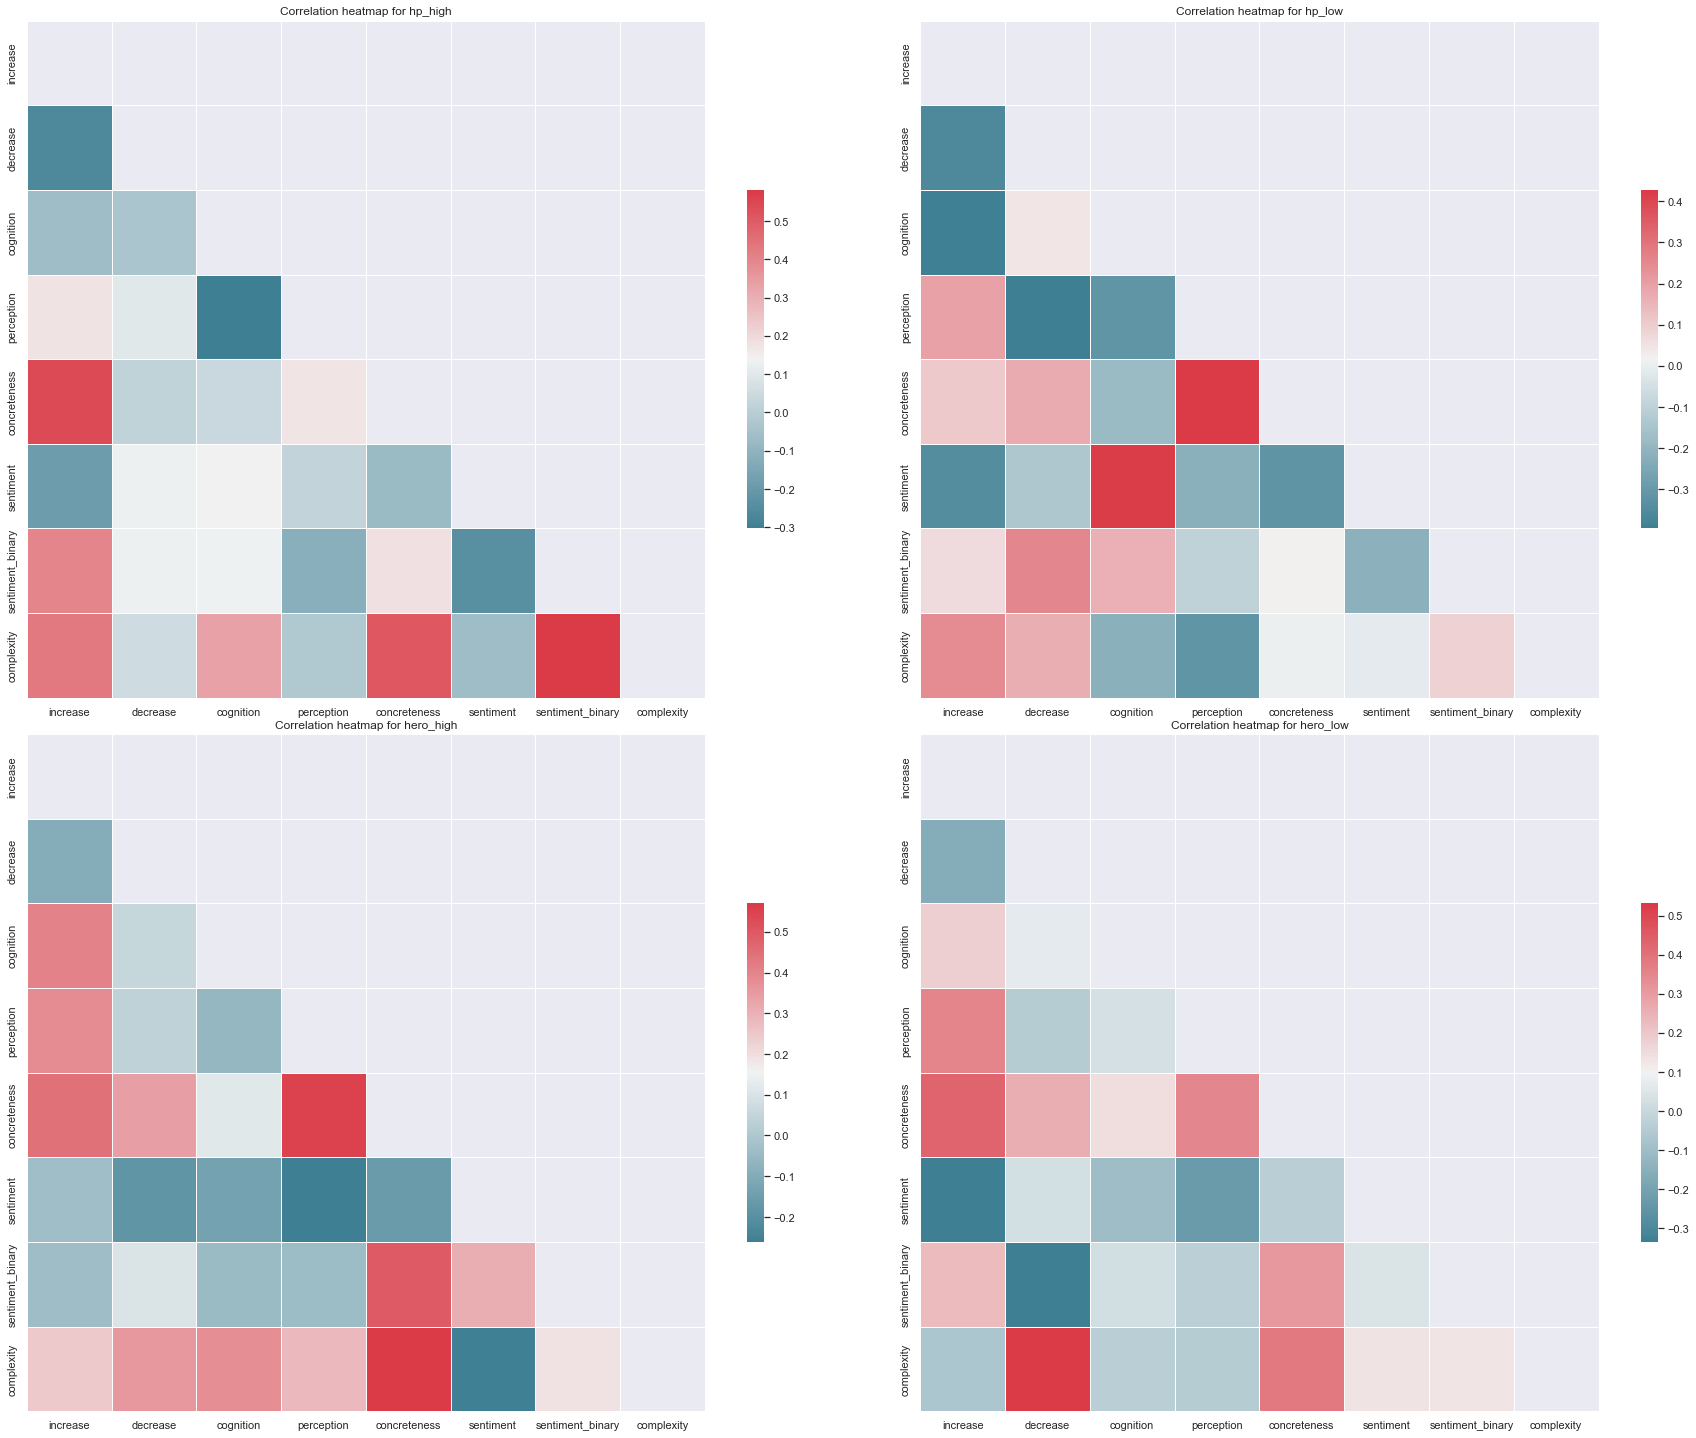

In [51]:
corr = dict(zip(all_stories, np.zeros(len(all_stories))))
f, ax = plt.subplots(2, 2)
count = 0
axes = [[0, 0], [0, 1], [1, 0], [1, 1]]
f.tight_layout()

for story in all_stories:
    ax1 = axes[count][0]
    ax2 = axes[count][1]

    # Compute the correlation matrix
    corr[story] = pairplot_norm[story].drop(['combined'], axis=1).corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr[story], dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr[story],
        mask=mask,
        cmap=cmap,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        ax=ax[ax1, ax2]
    )
    ax[ax1, ax2].set_title(f"Correlation heatmap for {story}")
    print(f"Correlation for {story}")
    display(corr[story])
    count += 1

plt.show()



,increase,decrease,cognition,perception,concreteness,sentiment,sentiment_binary,complexity
increase,1.000000,-0.229900,-0.003769,0.187640,0.336822,-0.171728,0.157166,0.280391
decrease,-0.229900,1.000000,0.053934,0.021048,0.257958,-0.053373,0.086976,0.263822
cognition,-0.003769,0.053934,1.000000,-0.109354,0.070500,0.075261,0.101000,0.172263
perception,0.187640,0.021048,-0.109354,1.000000,0.398840,-0.162563,-0.006855,0.027087
concreteness,0.336822,0.257958,0.070500,0.398840,1.000000,-0.150260,0.293020,0.439782
sentiment,-0.171728,-0.053373,0.075261,-0.162563,-0.150260,1.000000,-0.000904,-0.041835
sentiment_binary,0.157166,0.086976,0.101000,-0.006855,0.293020,-0.000904,1.000000,0.318408
complexity,0.280391,0.263822,0.172263,0.027087,0.439782,-0.041835,0.318408,1.000000


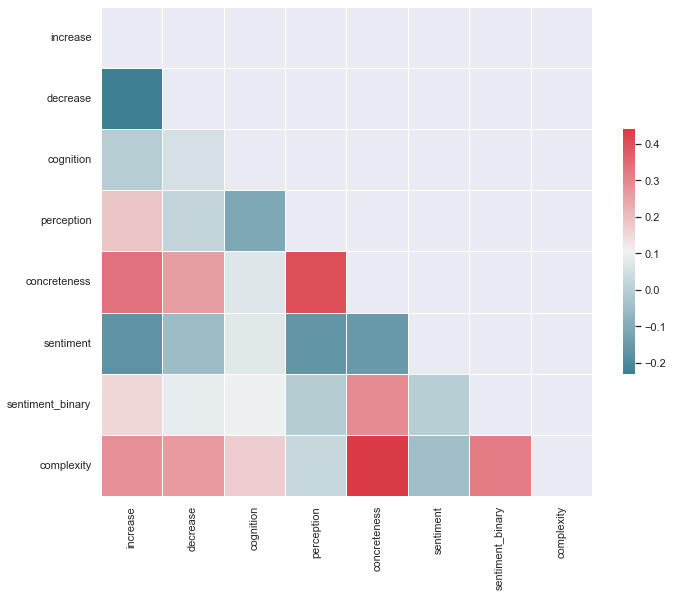

In [52]:
drop_cols = ['combined']
stories_concat = pd.concat( [pairplot_norm['hero_high'].drop(drop_cols, axis=1), 
pairplot_norm['hero_low'].drop(drop_cols, axis=1),
pairplot_norm['hp_high'].drop(drop_cols, axis=1),
pairplot_norm['hp_low'].drop(drop_cols, axis=1)], axis=0)
# stories_concat = pairplot_df['hp_high']
# Compute the correlation matrix
corr = stories_concat.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(
   corr,
   mask=mask,
   cmap=cmap,
   linewidths=0.5,
   cbar_kws={"shrink": 0.5},
   ax=ax
)
display(corr)

plt.show()